In [1]:
run __init__.py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
init_notebook_mode(connected=True)
from joblib import load, dump
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from langdetect import detect
from word2vec import make_model, class_weights_ohe, compute_aucs
from project import Project
from nlp import NLP_stat
from finnhub_api import Finnhub
from datetime_util import timestamp2datetime, str2date, str2datetime

[nltk_data] Downloading package stopwords to /Users/boula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/boula/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/boula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
keras.__version__

'2.3.0'

## Data Collecting

In [3]:
# loading news data scrapted by SNA api
df_news = pd.read_csv('./data/apple_news_raw.csv.gz')

In [4]:
# loading articles list previously scraped by scrapy.py we include in ./lib
articles = load('./data/articles.pkl')

In [5]:
df_news['articles'] = articles

In [6]:
df_news.head(3)

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,articles
0,https://www.cnbc.com/2021/05/25/home-prices-in...,https://cdn.snapi.dev/images/v1/b/m/104669168-...,Home prices in March saw highest growth in ove...,"Home prices in March were up 13%, one of the l...",CNBC,"Tue, 25 May 2021 09:01:19 -0400",[],Neutral,Article,NaN,Home prices in March were 13.2% higher in Mar...
1,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/a/s/m02d202105...,U.S. home prices rose more than expected in Ma...,U.S. single-family home prices in 20 key urban...,Reuters,"Tue, 25 May 2021 09:09:00 -0400",[],Neutral,Article,NaN,U.S. single-family home prices in 20 key urban...
2,https://www.reuters.com/article/us-usa-economy...,https://cdn.snapi.dev/images/v1/8/c/m02d202105...,U.S. new home sales drop in April; March sales...,Sales of new U.S. single-family homes dropped ...,Reuters,"Tue, 25 May 2021 10:33:00 -0400",[],Negative,Article,NaN,A carpenter works on building new townhomes th...


## Data Scrubbing

In [7]:
# drop unnecessary columns
cols_to_drop = ['news_url', 'image_url', 'title', 'text', 'topics', 'type', 'tickers']
df_news.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
df_news

,source_name,date,sentiment,articles
0,CNBC,"Tue, 25 May 2021 09:01:19 -0400",Neutral,Home prices in March were 13.2% higher in Mar...
1,Reuters,"Tue, 25 May 2021 09:09:00 -0400",Neutral,U.S. single-family home prices in 20 key urban...
2,Reuters,"Tue, 25 May 2021 10:33:00 -0400",Negative,A carpenter works on building new townhomes th...
3,Reuters,"Tue, 25 May 2021 07:10:00 -0400",Positive,Wall Street bank chiefs will tout the role the...
4,CNN Business,"Tue, 25 May 2021 12:30:41 -0400",Negative,"By Paul R. La Monica, CNN Business Updated 12..."
...,...,...,...,...
10445,CNET,"Mon, 26 Apr 2021 15:14:00 -0400",Negative,Tim Cook and Mark Zuckerberg's relationship st...
10446,Proactive Investors,"Mon, 26 Apr 2021 04:54:18 -0400",Neutral,Pharma & Biotech Coronavirus Cannabis Battery ...
10447,Zacks Investment Research,"Mon, 26 Apr 2021 17:31:17 -0400",Positive,We use cookies to understand how you use our s...
10448,The Motley Fool,"Sun, 25 Apr 2021 12:35:00 -0400",Positive,Returns as of 5/27/2021 Returns as of 5/27/202...


In [9]:
miss_articles = df_news['articles'].isna()
print(f"Total Missing Articles: {miss_articles.sum()}")

Total Missing Articles: 923


As result of scraping 10,450 websites we got 91.13% of successful scraped articles, but we also end up missing  926 websites. this probably due to websites restriction like cookies and CAPTCHA Blocking,  IP Blocking & Proxy Servers, etc..

those 926 row are going to be droped from our dataframe

In [10]:
df_news.drop(df_news.loc[miss_articles].index, inplace=True)

In [11]:
df_news.reset_index(drop=True, inplace=True)

#### DateTime

In [12]:
df_news.loc[:5,'date']

0    Tue, 25 May 2021 09:01:19 -0400
1    Tue, 25 May 2021 09:09:00 -0400
2    Tue, 25 May 2021 10:33:00 -0400
3    Tue, 25 May 2021 07:10:00 -0400
4    Tue, 25 May 2021 12:30:41 -0400
5    Tue, 25 May 2021 02:07:04 -0400
Name: date, dtype: object

In [13]:
df_news['date'].str.findall("\s-[0-9]{4}$").apply(lambda x: ''.join(x)).unique()

array([' -0400', ' -0500'], dtype=object)

In [14]:
# we found dates end with noise strings like '-0400' and '-0500', those are going to be removed using
# builin pandas RegEx.
df_news['date'] = df_news['date'].str.replace("\s-[0-9]{4}$", '', regex=True)

In [15]:
# convert date from string date format to DateTime object using standard ISO-8601 formated YYYY-MM-DDTHH:MM:SS.
df_news['date'] = pd.to_datetime(df_news['date'], format="%a, %d %b %Y %H:%M:%S")

In [16]:
df_news.loc[:5,'date']

0   2021-05-25 09:01:19
1   2021-05-25 09:09:00
2   2021-05-25 10:33:00
3   2021-05-25 07:10:00
4   2021-05-25 12:30:41
5   2021-05-25 02:07:04
Name: date, dtype: datetime64[ns]

In [17]:
df_news['date'] = pd.to_datetime(df_news['date']).dt.normalize()

In [18]:
df_news.rename(columns={'source_name':'source'}, inplace=True)

Using langdetect in order to indentify articles language, ensure articles are only english

In [19]:
df_news.reset_index(drop=True, inplace=True)

In [20]:
df_news.head()

,source,date,sentiment,articles
0,CNBC,2021-05-25,Neutral,Home prices in March were 13.2% higher in Mar...
1,Reuters,2021-05-25,Neutral,U.S. single-family home prices in 20 key urban...
2,Reuters,2021-05-25,Negative,A carpenter works on building new townhomes th...
3,Reuters,2021-05-25,Positive,Wall Street bank chiefs will tout the role the...
4,CNN Business,2021-05-25,Negative,"By Paul R. La Monica, CNN Business Updated 12..."


## PREPROCESSING

In this section we start by preparing our data for modeling, first by cleaning and tokenizing the articles text applying the function 'text_tokenize' and lastely evaluate the sentiment analysis applying 'polarity_score function.

Text Tonkenization

Remove punctuation, special characters, numbers

In [21]:
prep = NLP_stat()

In [22]:
df_news['articles'] = df_news['articles'].apply(lambda txt: txt.lower())

In [23]:
stop_words=stopwords.words('english')
df_news['articles'] = df_news['articles']\
                            .apply(lambda txt: ' '.join([word for word in txt.split() if word not in stop_words]))

In [24]:
df_news['articles'] = df_news['articles'].apply(lambda txt: sent_tokenize(txt))
df_news['articles'] = df_news['articles'].apply(lambda x: ' '.join(x))

In [25]:
word_tokenizer = RegexpTokenizer('[a-zA-Z]+')
df_news['articles'] = df_news['articles'].apply(lambda txt: word_tokenizer.tokenize(txt))
df_news['articles'] = df_news['articles'].apply(lambda txt: ' '.join(txt))

In [26]:
single_chars = re.compile(r"(^\w{1})(?=\s)|(?<=\s)[\w]{1}(?=\s)")
df_news['articles'] = df_news['articles'].apply(lambda txt: single_chars.sub('', txt))

In [27]:
articles_to_drop = df_news[(df_news['articles'].apply(lambda x: len(x.split()) <= 10))].index
df_news.drop(articles_to_drop, inplace=True)

In [28]:
df_news.reset_index(drop=True, inplace=True)

In [30]:
df_news.to_csv('./data/apple_news_cleaned.csv.gz', compression="gzip")

## Features Engineering

In [73]:
df_news = pd.read_csv('./data/apple_news_cleaned.csv.gz', index_col=0)

In [91]:
prep = NLP_stat()

In [92]:
df_score = prep.polarity_score(df_news['articles'])

In [93]:
df_news = pd.concat([df_news.drop('articles', axis=1), df_score], axis=1, ignore_index=False, sort=False)

In [33]:
df_news.rename(columns={"text":"articles"}, inplace=True)

In [34]:
# create a Frequency Distribution of postive words
positive_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Positive')].loc[:,'articles'] )
) 

In [35]:
# create a Frequency Distribution of negative words
negative_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Negative')].loc[:,'articles'] )
) 

In [36]:
# create a Frequency Distribution of neutral words
neutral_fdist_df = prep.get_freq_dist(
    prep.get_word_list( df_news[(df_news['sentiment'] == 'Neutral')].loc[:,'articles'] )
) 

In [37]:
# create a Frequency Distribution of all words
fdist_df = prep.get_freq_dist(prep.get_word_list(df_news['articles']))

In [38]:
df_news['sentiment'].value_counts()

Positive    4356
Neutral     3024
Negative    2140
Name: sentiment, dtype: int64

In [39]:
df_news.reset_index(drop=True, inplace=True)

In [41]:
df_news['word_count'] = prep.WordsCount(df_news['articles'])

## Exploratory Data Analysis

In [20]:
df_news.head()

,source,date,sentiment,articles,neg,neu,pos,comp,sent,word_count
0,CNBC,2021-05-25,Neutral,home prices march higher march compared march ...,0.077,0.799,0.124,0.9393,positive,271
1,Reuters,2021-05-25,Neutral,single family home prices key urban markets ...,0.064,0.812,0.124,0.9186,positive,241
2,Reuters,2021-05-25,Negative,carpenter works building new townhomes still c...,0.071,0.841,0.088,0.8176,positive,396
3,Reuters,2021-05-25,Positive,wall street bank chiefs tout role institutions...,0.102,0.765,0.132,0.9019,positive,547
4,CNN Business,2021-05-25,Negative,paul la monica cnn business updated pm et tue...,0.073,0.927,0.000,-0.2960,negative,29


In [21]:
sentiment = df_news['sentiment'].value_counts()

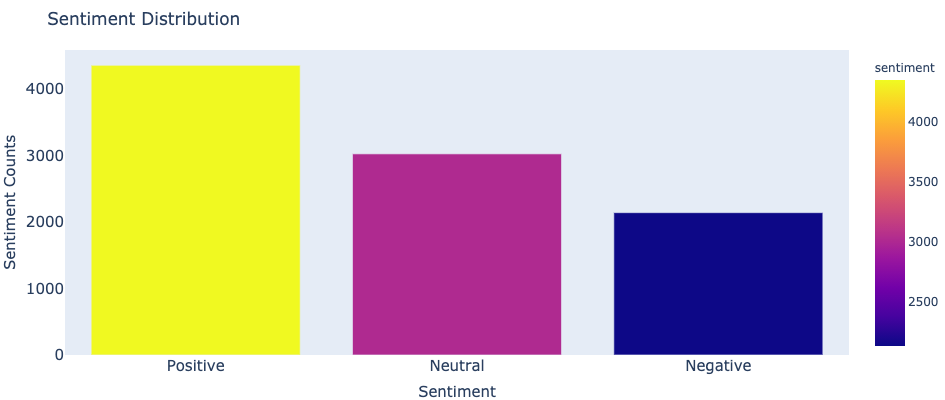

In [22]:
fig1 = px.bar(sentiment,
              x=sentiment.index,
              y='sentiment',
              color='sentiment'
             )
fig1.update_layout(
            height=400,
            width=700,
            margin={"r":0,"t":50,"l":0,"b":0},
            paper_bgcolor='white',
            title='Sentiment Distribution',
            xaxis_zeroline=False, 
            yaxis_zeroline=False,
    xaxis=dict(
            title='Sentiment',
            linecolor=None,
            titlefont_size=15,
            tickfont_size=15,
            showgrid=False
            ),
    yaxis=dict(
            title='Sentiment Counts',
            linecolor=None,
            titlefont_size=15,
            tickfont_size=15,
            showgrid=False
            ),
    legend=dict(
            x=0,
            y=0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
            )
                    )
iplot(fig1)

In [23]:
source_top10 = df_news['source'].value_counts(sort=True).nlargest(10)

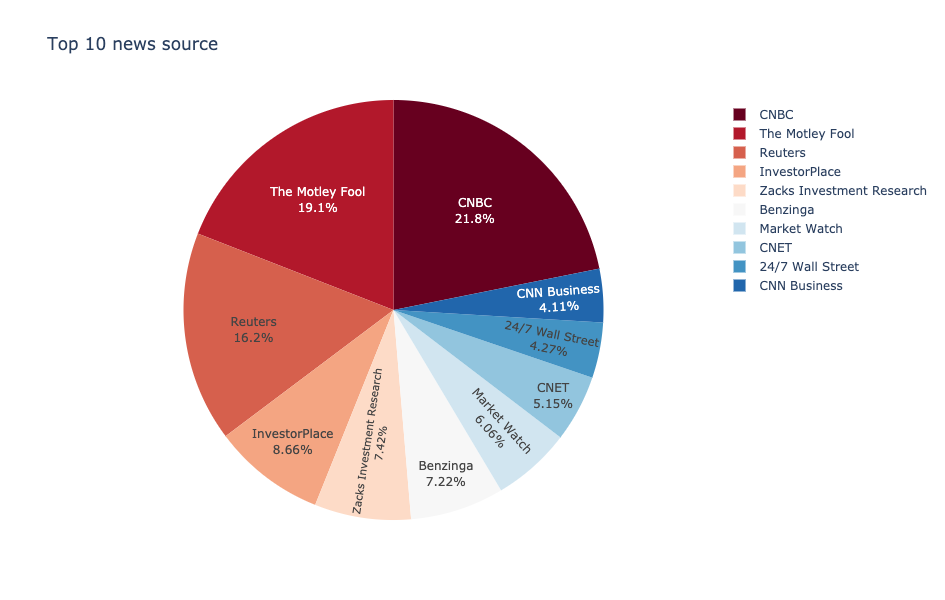

In [24]:
fig2 = px.pie(source_top10,
              values='source',
              names=source_top10.index,
              title='Top 10 news source',
              color_discrete_sequence=px.colors.sequential.RdBu,
              width=800,
              height=600,
              labels=source_top10.index
             )

fig2.update_traces(hoverinfo='label+percent',
                   textfont_size=12,
                   textposition='inside',
                   textinfo='percent+label'
                  )
iplot(fig2)

In [25]:
sent_vs_source_df = (
    df_news.groupby(['sentiment','source'])
    .size().reset_index()
    .rename(columns={0:'count'})
    .query("count > 50")
                    )

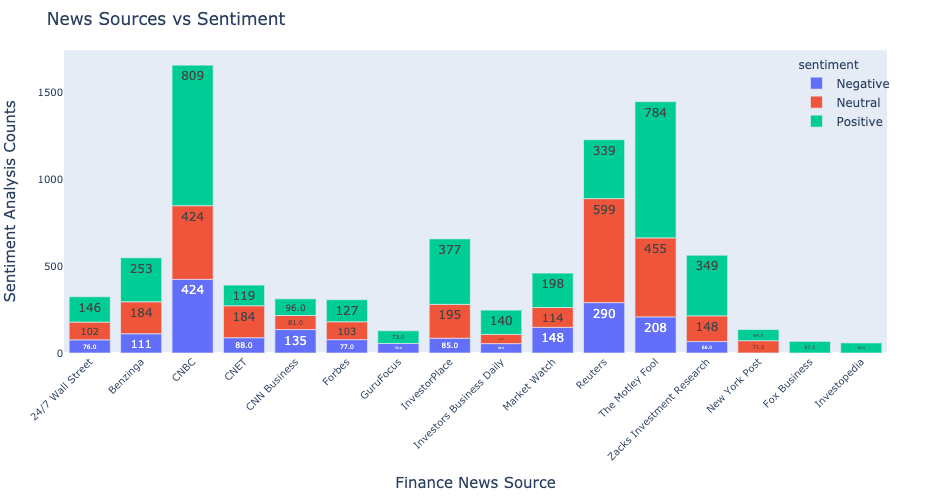

In [26]:
fig3 = px.bar(
    sent_vs_source_df,
    x='source',
    y='count',
    text='count',
    color='sentiment',
    title='News Sources vs Sentiment'
)
fig3.update_layout(
    width=1000,
    height=500,
    margin={"r":50,"t":50,"l":50,"b":50},
    uniformtext_minsize=6,

xaxis=dict(
    title='Finance News Source',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False,
    tickangle=-45
    ),
yaxis=dict(
    title='Sentiment Analysis Counts',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False
    ),    
legend=dict(
    yanchor="top",
    xanchor="left",
    x=0.89,
    y=0.99,
    bgcolor='rgba(255, 255, 255, 0)',
    bordercolor='rgba(255, 255, 255, 0)'
            )    
                )
fig3.update_traces(texttemplate='%{text:.3s}', textposition='inside')
iplot(fig3)

In [29]:
word_freq_dist = pd.concat(
    [
    (neutral_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='neutral')
     .sample(15, replace=True)),
    (negative_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='negative')
     .sample(15, replace=True)),        
    (positive_fdist_df
     .query("frequency > 1000")
     .assign(sentiment='positive')
     .sample(15, replace=True))
    ],
    ignore_index=True, axis=0
            )

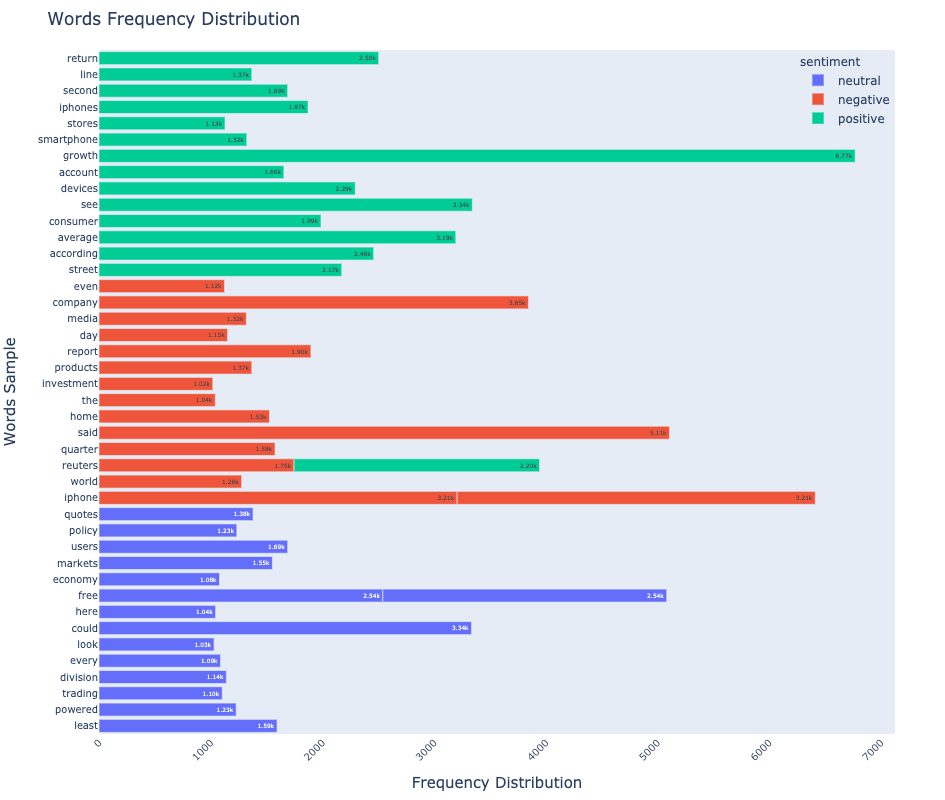

In [30]:
fig3 = px.bar(
    word_freq_dist,
    x='frequency',
    y='word',
    text='frequency',
    color='sentiment',
    title='Words Frequency Distribution'
)
fig3.update_layout(
    width=900,
    height=800,
    margin={"r":50,"t":50,"l":50,"b":50},
    uniformtext_minsize=6,

xaxis=dict(
    title='Frequency Distribution',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False,
    tickangle=-45
    ),
yaxis=dict(
    title='Words Sample',
    linecolor=None,
    titlefont_size=15,
    tickfont_size=10,
    showgrid=False
    ),    
legend=dict(
    yanchor="top",
    xanchor="right",
    x=1,
    y=1,
    bgcolor='rgba(255, 255, 255, 0)',
    bordercolor='rgba(255, 255, 255, 0)'
            )    
                )
fig3.update_traces(texttemplate='%{text:.3s}', textposition='inside')
iplot(fig3)

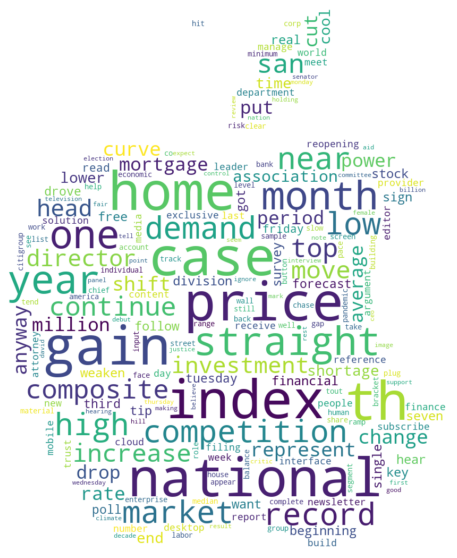

In [19]:
mask = load('./data/aapl_mask.pkl')
fig = plt.subplots(figsize=(20,10))
wc = WordCloud(
    mask=mask,
    ranks_only=True,
    background_color="white",
    collocations=True,
    max_words=200,
    max_font_size=100,
    random_state=42,
    width=1200,
    height=800
    )
wc.generate(' '.join(fdist_df.word.to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('./img/word_cloud.jpg',format="jpg")
plt.show()

## MODELING

In [8]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(apple_news_df['sentiment'].values.reshape(-1,1))

In [9]:
max_lenght = 100
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(apple_news_df['articles'])
sequences = tokenizer.texts_to_sequences(apple_news_df['articles'])
word_index = tokenizer.word_index
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer.word_index) + 1
data = pad_sequences(sequences, max_lenght)

In [10]:
print(f"{'Unique Words':25} {len(tokenizer.index_word)}")
print(f"{'Shape of data tensor':25} {data.shape}")
print(f"{'Shape of label tensor':25} {y_ohe.shape}")

Unique Words              36867
Shape of data tensor      (9520, 100)
Shape of label tensor     (9520, 3)


In [6]:
sentences = apple_news_df['articles'].apply(lambda x: x.split()).to_list()

In [ ]:
word2vec = Word2Vec(sentences,
                     vector_size=max_lenght,
                     window=5,
                     min_count=1,
                     workers=4,
                    )

In [17]:
word2vec.train(sentences, total_examples=word2vec.corpus_count, epochs=5)

(19036557, 19855725)

In [18]:
pretrained_weights = word2vec.wv.vectors

In [19]:
vocab_size, emdedding_size = pretrained_weights.shape
vectors = np.asarray(word2vec.wv.vectors)

In [21]:
len(word_index), len(word2vec.wv.key_to_index)

(36867, 36867)

In [22]:
embedding_matrix = np.zeros((vocab_size+1, emdedding_size))
for word, idx in word_index.items():
        embedding_matrix[idx] = word2vec.wv[word]

In [ ]:
dump(embedding_matrix, './word2vec/embedding_matrix.pkl', compress=5)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, y_ohe, test_size=.15, random_state=1, stratify=y_ohe)
X_train, X_val, y_train, y_val   = train_test_split(data, y_ohe, test_size=.15, random_state=1, stratify=y_ohe)

print(f"Train\n\t{'X :':5}{X_train.shape}\n\t{'Y :':5}{y_train.shape}")
print(f"Test\n\t{'X :':5}{X_test.shape}\n\t{'Y :':5}{y_test.shape}")
print(f"Validation\n\t{'X :':5}{X_val.shape}\n\t{'Y :':5}{y_val.shape}")

Train
	X :  (8092, 100)
	Y :  (8092, 3)
Test
	X :  (1428, 100)
	Y :  (1428, 3)
Validation
	X :  (1428, 100)
	Y :  (1428, 3)


In [13]:
input_dim = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = data.shape[1]

In [14]:
EPOCHS = 32
BATCH_SIZE = 1024
BIAS = class_weights_ohe(y_ohe)
auc = metrics=keras.metrics.AUC()
METRICS = [auc]
STEPS_x_EPOCH = X_train.shape[0]//BATCH_SIZE
VAL_SPLIT = X_val.shape[0]//BATCH_SIZE

In [15]:
plot_model = Ploty()

In [16]:
eStop_Val_Loss = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=12,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Loss     = EarlyStopping(monitor='loss', min_delta=0.001, patience=8,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Val_AUC = EarlyStopping(monitor='val_auc_1', min_delta=0.001, patience=12,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)

In [17]:
model = make_model(METRICS,
                   input_dim=input_dim,
                   embedding_dim=embedding_dim,
                   weights=embedding_matrix,
                   input_length=max_seq_len,
                  )

In [18]:
model.layers[-1].bias = BIAS
embedding_init =  keras.initializers.zeros()
model.layers[0].embeddings_initializer = embedding_init

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3686800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense16 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output4 (Dense)              (None, 3)                

In [20]:
history = model.fit(
                    X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    use_multiprocessing = True,
                    workers=8
                    )

Train on 8092 samples, validate on 1428 samples
Epoch 1/32
8092/8092 [==============================] - 30s 4ms/step - loss: 1.0745 - auc_1: 0.5973 - val_loss: 1.0262 - val_auc_1: 0.6616
Epoch 2/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0364 - auc_1: 0.6525 - val_loss: 1.0140 - val_auc_1: 0.6773
Epoch 3/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0270 - auc_1: 0.6622 - val_loss: 1.0081 - val_auc_1: 0.6834
Epoch 4/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0221 - auc_1: 0.6685 - val_loss: 1.0025 - val_auc_1: 0.6891
Epoch 5/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0168 - auc_1: 0.6737 - val_loss: 0.9965 - val_auc_1: 0.6939
Epoch 6/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0110 - auc_1: 0.6797 - val_loss: 0.9953 - val_auc_1: 0.6951
Epoch 7/32
8092/8092 [==============================] - 23s 3ms/step - loss: 1.0005 - auc_1: 0.6900 - val_loss: 0.9861

In [22]:
model.save('./model/model.h5')

In [23]:
history = model.fit(
                    X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    use_multiprocessing = True,
                    callbacks=[eStop_Val_AUC ,eStop_Val_Loss],
                    workers=8
                    )

Train on 8092 samples, validate on 1428 samples
Epoch 1/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6707 - auc_1: 0.8777 - val_loss: 0.9933 - val_auc_1: 0.7755
Epoch 2/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6569 - auc_1: 0.8829 - val_loss: 1.0243 - val_auc_1: 0.7682
Epoch 3/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6429 - auc_1: 0.8881 - val_loss: 1.0570 - val_auc_1: 0.7647
Epoch 4/32
8092/8092 [==============================] - 24s 3ms/step - loss: 0.6463 - auc_1: 0.8884 - val_loss: 1.0150 - val_auc_1: 0.7704
Epoch 5/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6408 - auc_1: 0.8896 - val_loss: 1.0120 - val_auc_1: 0.7737
Epoch 6/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6288 - auc_1: 0.8937 - val_loss: 1.0598 - val_auc_1: 0.7689
Epoch 7/32
8092/8092 [==============================] - 23s 3ms/step - loss: 0.6115 - auc_1: 0.8998 - val_loss: 1.0393

In [ ]:
score = model.evaluate(X_test, y_test, steps=X_test.shape[0], workers=8, verbose=0)

#### Computer AUC Accuracy 

In [28]:
y_pred = model.predict(X_test, batch_size=1,verbose=0)

In [14]:
classes_accurasy = compute_aucs(y_pred, y_test)

In [101]:
model_stat_df = pd.DataFrame({"accuracy":classes_accurasy, 'classes':ohe.categories_[0], 'bias':BIAS})

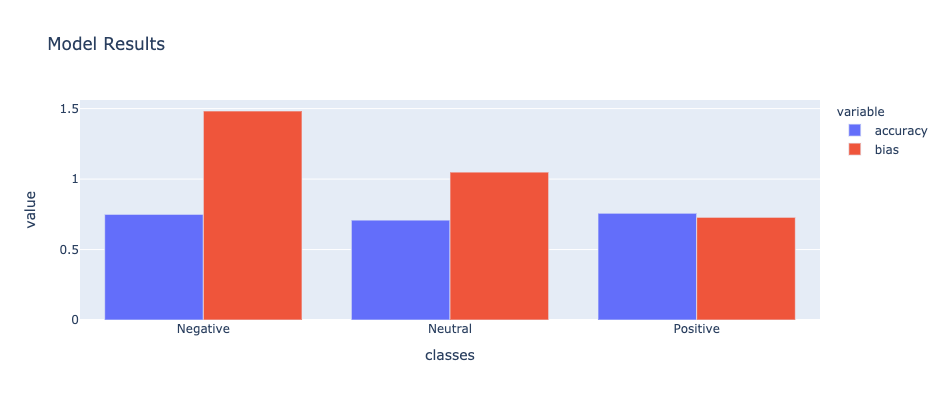

In [160]:
fig_cls = px.bar(model_stat_df,
                 x='classes',
                 y=['accuracy', 'bias'],
                 labels={'x': 'Class Name', 'y':'Accuracy'},
                 width=500,
                 height=400,
                 title='Model Results',
                 barmode='group',
                )
fig_cls.show()

In [29]:
print('Accuracy :', score[1])

Accuracy : 1103.075835943222


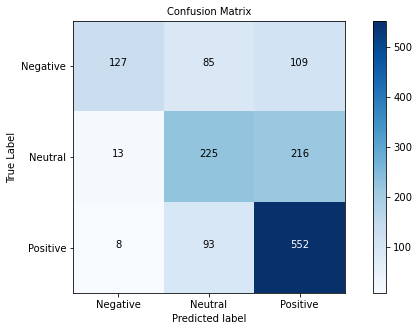

In [30]:
plot_model.confusion_matrix(y_true=y_test, y_pred=y_pred, target_name=ohe.categories_[0], file_name='./img/cm.jpg')

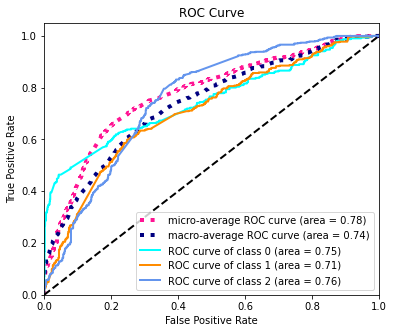

In [31]:
plot_model.plot_roc_curve(y_true=y_test, y_pred=y_pred, file_name='./img/roc.jpg')

## Interpretation

#### The method we used in our project to do sentiement analysis and price forcasting includes 2 magior modeling approaches:

- Sentiment Analysis Prediction
  - the two major methods we used to do sentiment analysis includes Recurrent Neural Network (RNN) model constructed with Embedding layer and LSTM bidirectional layer where we intialized with the embedding matrix learned from Gensim Word2Vec pretrained Model.
- Stock Market Price Prediction
  - the second model is focused on statistical approach using SARIMAX model for a short-term time series forecasting and predicting the stock market trend.

## Conclusion

- Since our dataset is completely scrapped from various financial news sources, we end up with an unbalanced dataset where the negative class represent only 22% of our data, however the model did pretty good with 78% of Accuracy as well as  "ROC" which obtained 74% for both "True Positive Rate" & "False Positive Rate".

- Similarly, the second dataset we used on predicting the time series and stock market price are not stationary and represent an exponential trend, however SARIMAX model are able to predict the future values of the stock price for the upcoming 6 period (30 minutes).

## Future Work

- Improve web scraping technique using different API
- Use SQL database to improve our project performance.
- Create a real-time Dashboard for predicting market sentiment and price forecasting